# The Kalman Net - A Neural Network aided kalman filtering

The Kalman Net is a neural network architecture that aids the Kalman filter in adaptively learning the process noise statistics and measurement noise statistics using labeled data.

Source:
- [https://arxiv.org/pdf/2107.10043.pdf](https://arxiv.org/pdf/2107.10043.pdf)


## The Radar Problem

In this notebook, I will implement a simple kalman net for a toy non-linear system for predicting the position of a moving object. The toy problem involves a radar that measures distance to a moving 
object. The observable in this case is the "slant range" which is the distance between the radar and the object. Based on this measurement, we want to predict the x and y position of the object.\


State Definition:
- x: x position of the object
- x_vel: x velocity of the object
- alt or y : y position of the object

The motion is a simple model where the object moves in a straight line with constant velocity. The state transition model is given by:
$$
F = \begin{bmatrix}
1 & \Delta t & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}

$$

The measurement model is given by:
$$
h(x,y) = \sqrt{x^2 + y^2}
$$

Clearly one can see that the measurement model is non-linear but the kalman net can handle non-linear models adaptively.


Let's start by desining the simulator for the radar problem. Here is a simple radar simulator that generates the true state and the measurements.

In [1]:
import torch

class RadarSim:
    """Simulates the radar signal returns from an object with
    a constant velocity and altitude. The radar is assumed to be
    """

    def __init__(
        self, dt: float, pos: float, vel: float, alt: float, std: float = 0.3
    ) -> None:
        """Initializes the radar simulation.

        Args:
            dt (float): Time step between measurements.
            pos (float): Initial position of the object.
            vel (float): Constant velocity of the object.
            alt (float): Constant altitude of the object.
            noise (float, optional): Measurement noise. Defaults to 0.0.
        """
        self.pos = torch.tensor([pos])
        self.vel = torch.tensor([vel])
        self.alt = torch.tensor([alt])
        self.dt = dt
        self.std = std

    def get_range(self):
        """Returns the slant distance to the object.

        Returns:
            float: Slant distance to the object.
        """

        # add some process noise to the system
        self.vel = self.vel + 0.1 * torch.normal(0, self.std, (1,))
        self.alt = self.alt + 0.1 * torch.normal(0, self.std, (1,))
        self.pos = self.pos + self.vel * self.dt

        # add measurement noise
        err = self.pos * 0.05 * torch.normal(0, self.std, (1,))
        slant_dist = torch.sqrt(self.pos**2 + self.alt**2)

        return slant_dist + err

    def get_n_measurement_and_truth(self, n: int):
        """Returns n measurements and the corresponding truth values.

        Args:
            n (int): Number of measurements to return.

        Returns:
            Tuple[Tensor, Tensor]: The measurements and the corresponding truth values.
        """
        measurements = []
        truths = []

        for _ in range(n):
            measurements.append(self.get_range())
            truths.append(torch.tensor([self.pos, self.vel, self.alt]))

        return torch.stack(measurements), torch.stack(truths)



Now the main part is to desing the Kalman Net for this problem which is pretty simple since all the components are already available in the `navigator.filters.kalman_nets` module. 

The first step to desing a kalman net is to import the `AbstractKalmanNet` class from the `navigator.filtes.kalman_nets` module. User need to override 
few of the methods to define the Kalman Net architecture. 

The original Kalman Net components are already implemented in the `navigator.filters.kalman_nets.gru_knet` module. We will use these components to design the Kalman Net for the radar problem.

In [2]:
from navigator.filters.kalman_nets import AbstractKalmanNet, GRUKalmanBlock, GRUExtendedKalmanBlock

# The Standerd Kalman Net
class RadarSimKalmanNet(AbstractKalmanNet):
    """RadarSimKalmanNet - Implements the radar simulation Kalman filter."""

    STATE_DIM = 3
    MEASUREMENT_DIM = 1

    def __init__(self, dt: float, flavor: list[str] | None = None, **kwargs):
        super().__init__(
            dim_state=self.STATE_DIM,
            dim_measurement=self.MEASUREMENT_DIM,
            dt=dt,
            flavor=flavor,
            max_history=2,
        )

        # Initialize a GRU cell
        self.network = GRUKalmanBlock(
            dim_state=self.STATE_DIM,
            dim_measurement=self.MEASUREMENT_DIM,
            flavours=flavor,
        )

        # Reset the internal state
        self.reset()

    def reset(self):
        """Resets the internal state for new filtering."""
        # In out case the hidden state is a tuple of the hidden state and the cell state
        self.hidden_state = torch.zeros(1 , self.network.hx_dim, dtype=self.dtype, device=self.device)

        # Call the parent reset_internal_state
        self.reset_internal_state(batch_dim=1)


    # This is the state transition function mentioned above
    def fx(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """The state transition function for the SingleDifferenceKalmanNet.

        Args:
            x (Tensor): The state tensor.

        Returns:
            Tensor: The predicted state tensor.
        """

        F = torch.tensor([[1, self.dt, 0], [0, 1, 0], [0, 0, 1]])

        return torch.matmul(F, x)

    def hx(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """The measurement function for the SingleDifferenceKalmanNet.

        Args:
            x (Tensor): The state tensor.
            sv_matrix (Tensor): The satellite vehicle matrix.

        Returns:
            Tensor: The predicted measurement tensor.

        Raises:
            ValueError: If the 'sv_matrix' and 'reference_sv' are not provided as keyword arguments.
        """
        # Return the predicted slant distance
        return torch.norm(x[[0, 2]])

    def calculate_kalman_gain(self, combinations: dict[str, torch.Tensor]) -> torch.Tensor:
        """Calculates the Kalman gain.

        Args:
            combinations (dict[str, Tensor]): The combinations of the covariance matrices.

        Returns:
            Tensor: The Kalman gain.
        """
        KG, self.hidden_state = self.network(combinations, self.hidden_state)

        # Return the Kalman gain
        return KG


class RadarSimExtendedKalmanNet(AbstractKalmanNet):
    """RadarSimExtendedKalmanNet - Implements the radar simulation Extended Kalman Net"""

    def __init__(self, dt: float, **kwargs):
        super().__init__(
            dim_state=3,
            dim_measurement=1,
            dt=dt,
            flavor=["F1", "F2", "F3", "F4"],
            **kwargs
        )

        # Initialize a GRU cell
        self.network = GRUExtendedKalmanBlock(
            dim_state=3,
            dim_measurement=1,
            flavours=self.flavor,
        )

        # Initialize the hidden state
        self.reset()
        

    def reset(self) -> None:
        """Resets the internal state for kalman filtering."""
        self.Q_GRU_HIDDEN_STATE = torch.zeros(1, self.network.Q_dim) # One here since the batch dim is 1 here 
        self.P_GRU_HIDDEN_STATE = torch.zeros(1, self.network.P_dim) # One here since the batch dim is 1 here
        self.S_GRU_HIDDEN_STATE = torch.zeros(1, self.network.S_dim) # One here since the batch dim is 1 here

        # Reset the kalman filter state of parent
        self.reset_internal_state(batch_dim=1)

    def calculate_kalman_gain(self, combinations: dict[str, torch.Tensor]) -> torch.Tensor:
        """Calculates the Kalman gain.

        Args:
            combinations (dict[str, Tensor]): The combinations of the covariance matrices.

        Returns:
            Tensor: The Kalman gain.
        """
        # Calculate the Kalman gain
        # Add the HIDEN_STATE To the combinations
        combinations[GRUExtendedKalmanBlock.Q_HIDDEN_KEY] = self.Q_GRU_HIDDEN_STATE
        combinations[GRUExtendedKalmanBlock.P_HIDDEN_KEY] = self.P_GRU_HIDDEN_STATE
        combinations[GRUExtendedKalmanBlock.S_HIDDEN_KEY] = self.S_GRU_HIDDEN_STATE

        # Calculate the Kalman gain
        output = self.network(combinations)

        # Update the hidden state
        self.Q_GRU_HIDDEN_STATE = output[GRUExtendedKalmanBlock.Q_HIDDEN_KEY]
        self.P_GRU_HIDDEN_STATE = output[GRUExtendedKalmanBlock.P_HIDDEN_KEY]
        self.S_GRU_HIDDEN_STATE =  output[GRUExtendedKalmanBlock.S_HIDDEN_KEY]

        # Return the Kalman gain
        return output["KG"]
    

    def fx(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """The state transition function for the SingleDifferenceKalmanNet.

        Args:
            x (Tensor): The state tensor.

        Returns:
            Tensor: The predicted state tensor.
        """

        F = torch.tensor([[1, self.dt, 0], [0, 1, 0], [0, 0, 1]])

        return torch.matmul(F, x)
    
    def hx(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """The measurement function for the SingleDifferenceKalmanNet.

        Args:
            x (Tensor): The state tensor.
            sv_matrix (Tensor): The satellite vehicle matrix.

        Returns:
            Tensor: The predicted measurement tensor.

        Raises:
            ValueError: If the 'sv_matrix' and 'reference_sv' are not provided as keyword arguments.
        """
        # Return the predicted slant distance
        return torch.norm(x[[0, 2]])


Here the radar sim is a data simulator that will simulate the noisy measurements from the radar. The kalman net will be trained on this noisy data since we have the ground truth state of the object for training purposes. However, the in testing time the kalman net will be used to predict the state of the object based on just the noisy measurements from the radar.

In [3]:
import torch
# Initialize the simulator
rsim = RadarSim(
    dt=0.1,
    pos=0,
    vel=100,
    alt=1000,
    std=0.5, # Control the noise level in the measurements
)

Here is a sample data how the radar measurements looks like compared to the ground truth state of the object.

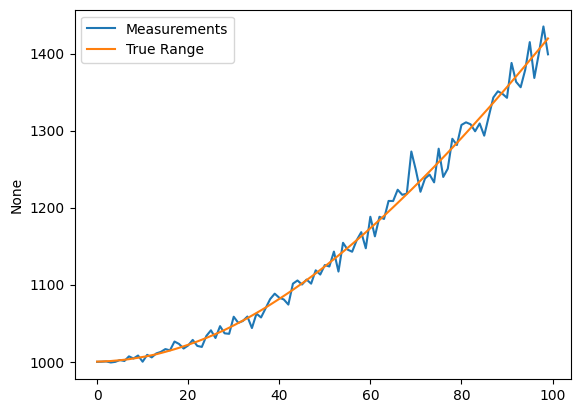

In [4]:
import seaborn as sns

# Grabs the first 100 measurements and true states
measurements, true_states = rsim.get_n_measurement_and_truth(100)

# Plot the measurements and true states
sns.lineplot(x=range(100), y=measurements.flatten(), label='Measurements')

# True range
sns.lineplot(x=range(100), y=torch.norm(true_states[:, [0,2]], dim=1), label='True Range');


As you can see the measurements are noisy and this is available for training of the kalman net. Let's instiate the kalman net and train it on this data.

In [5]:
# Initialize the Radar Kalman Net
knet =RadarSimKalmanNet(
    dt=0.1,
    flavor=["F1", "F4", "F3", "F2"]

)

extnet  =  RadarSimExtendedKalmanNet(
    dt=0.1,
)

extnet = knet

Below is the training loop for the kalman net. The kalman net is trained on the noisy measurements and the ground truth state of the object. The loss function is the MSE between the predicted state and the ground truth state. The kalman net is trained to minimize this loss.

In [6]:
from torch.nn import  MSELoss
from torch.optim import Adam

# Loss and optimizer
criterion = MSELoss()
optimizer = Adam(knet.parameters(), lr=0.01, weight_decay=1e-3)

# The residual between the true state and the predicted state
losses = []

# Train the model
for epoch in range(200):
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Reset filter state
    knet.reset()
    # Generate a measurement
    meas, true = rsim.get_n_measurement_and_truth(10)
    
    predictions = []
    state_diff = []
    for i in range(len(meas)):
        # Forward pass
        knet.predict()
        predictions.append(knet.update(meas[i].unsqueeze(0)))
        state_diff.append(predictions[-1] - knet.state_tracker[-2])
    
    predictions = torch.vstack(predictions)
    # Loss Criterion
    x_position_loss = criterion(predictions[:,0], true[:,0]) 
    x_velocity_loss = criterion(predictions[:,1], true[:,1])
    altitude_loss = criterion(predictions[:,2], true[:,2])
    state_diff_loss = criterion(torch.vstack(state_diff), torch.zeros_like(torch.vstack(state_diff)))
    velocity_sucessive_loss = criterion(predictions[1:,1], predictions[:-1,1])
    
    # Weight the losses
    loss = 0.05 * x_position_loss + 100 * x_velocity_loss + 2* altitude_loss +  state_diff_loss  * 0.8 +   velocity_sucessive_loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
    losses.append(loss.item())

    # Backward pass
    loss.backward()
    optimizer.step()





Epoch 0 Loss: 8329964.5
Epoch 10 Loss: 426360.375
Epoch 20 Loss: 1286888.125
Epoch 30 Loss: 2658025.25
Epoch 40 Loss: 2145835.0
Epoch 50 Loss: 2043414.25
Epoch 60 Loss: 1532924.375
Epoch 70 Loss: 2066539.0
Epoch 80 Loss: 1262815.25
Epoch 90 Loss: 1803210.375
Epoch 100 Loss: 3810557.0
Epoch 110 Loss: 3392068.5
Epoch 120 Loss: 3508086.25
Epoch 130 Loss: 2877157.5
Epoch 140 Loss: 3155526.75
Epoch 150 Loss: 3704551.75
Epoch 160 Loss: 4111670.0
Epoch 170 Loss: 5170572.0
Epoch 180 Loss: 8031966.0
Epoch 190 Loss: 5690440.5


Let's see the loss curve of the residual error of the kalman net on the training data.

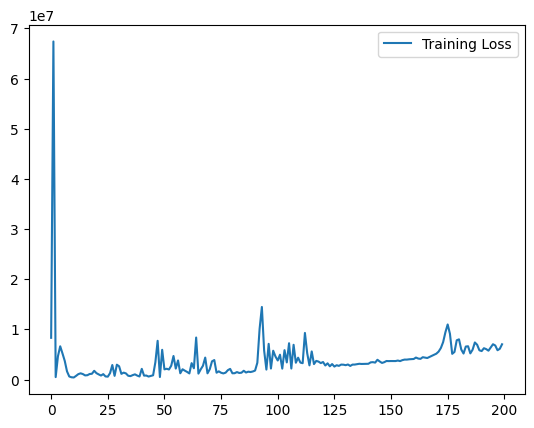

In [7]:
sns.lineplot(x=range(len(losses)), y=losses, label="Training Loss");

Clearly the kalman net is ables to minimize the residual error on the training data. It seem like traning for 60 epochs is enough for good convergence. Now let's grab new data from the radar simulator and see how the kalman net performs on the test data without the true state using just the noisy measurements.

In [8]:
# Predict the state from the measurement
# Get 500 new measurements and true states
meas, true = rsim.get_n_measurement_and_truth(500)

# Reset the filter for new predictions
knet.reset()

predictions = []
knet.eval()

# Predict the state from the measurement
with torch.no_grad():
    for i in range(len(meas)):
        knet.predict()
        predictions.append(knet.update(meas[i].unsqueeze(0)))

<Axes: ylabel='None'>

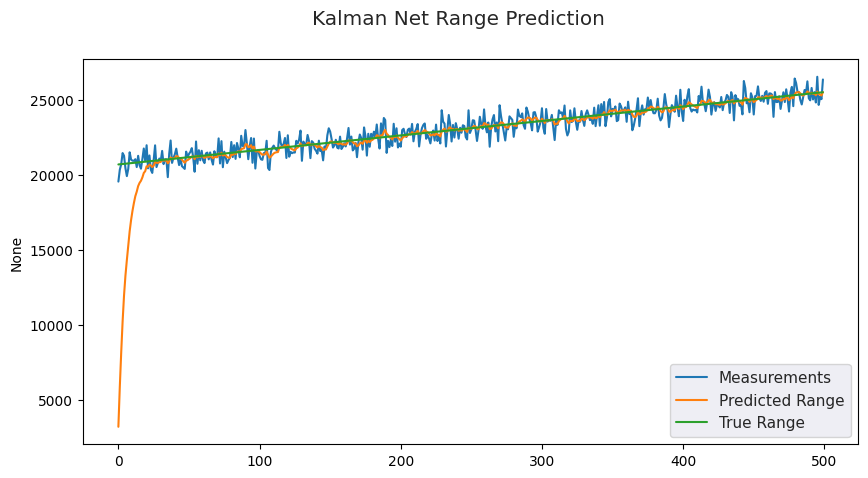

In [9]:
# Plot
import matplotlib.pyplot   as plt

# Stack the predictions
preds = torch.vstack(predictions)


fig , ax = plt.subplots(figsize=(10, 5))

sns.set_theme(style="darkgrid")

fig.suptitle("Kalman Net Range Prediction")
# Plot the measurements, true states, and predicted states
pred_range = torch.norm(preds[:, [0, 2]], dim=1)
true_range = torch.norm(true[:, [0, 2]], dim=1)

sns.lineplot(x=range(len(meas)), y=meas.flatten(), label='Measurements', ax=ax)
sns.lineplot(x=range(len(pred_range)), y=pred_range, label='Predicted Range', ax=ax)
sns.lineplot(x=range(len(true_range)), y=true_range, label='True Range', ax=ax)

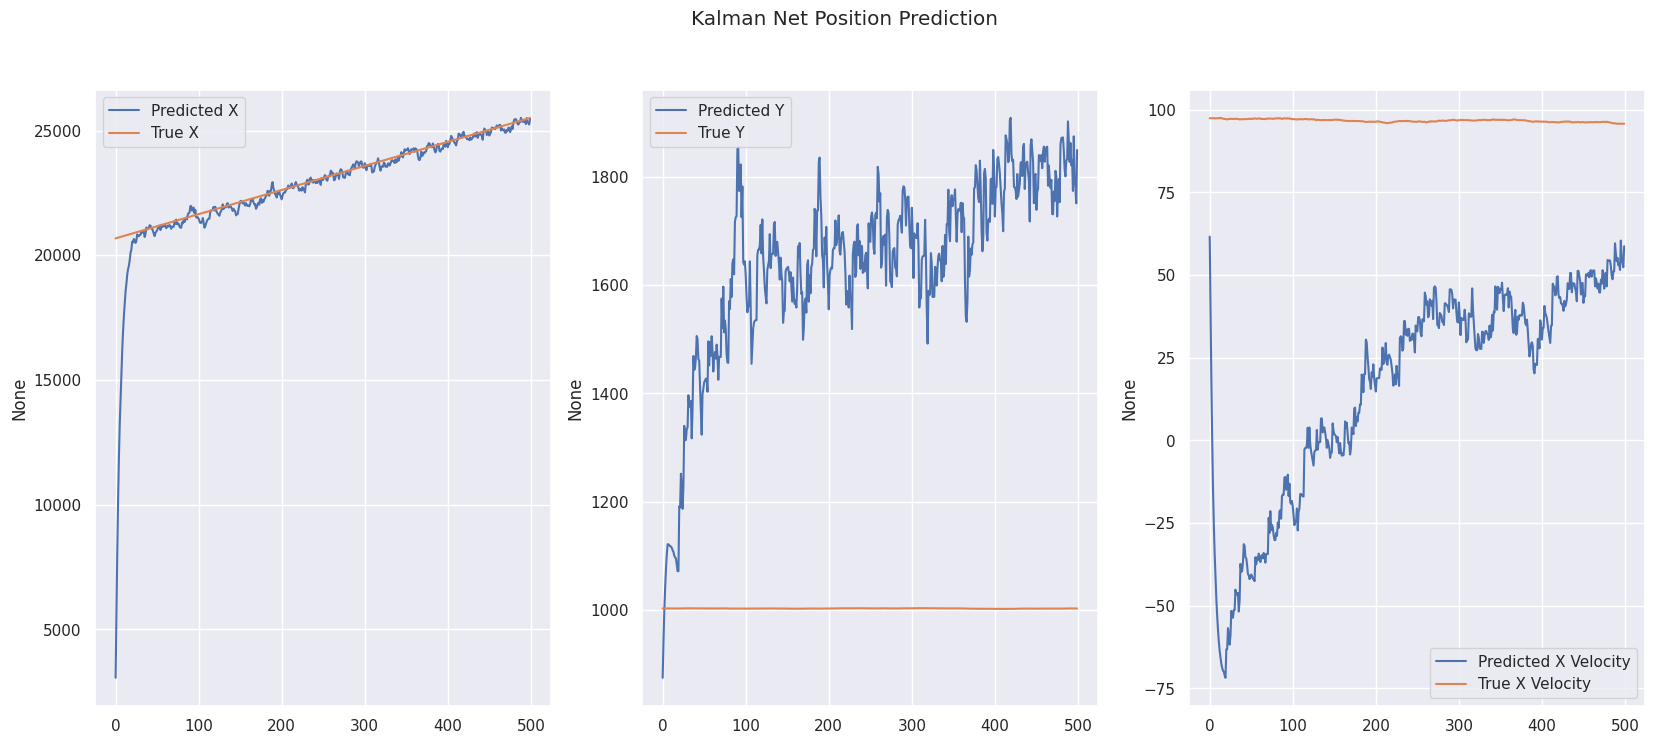

In [10]:
# Plot the measurements, true states, and predicted states for the Y position

fig , ax = plt.subplots(1, 3, figsize=(20, 8))

fig.suptitle("Kalman Net Position Prediction")

# Plot X on the first subplot
sns.lineplot(x=range(500), y=preds[:, 0], label='Predicted X', ax=ax[0])
sns.lineplot(x=range(500), y=true[:, 0], label='True X', ax=ax[0])

# Plot Y on the third subplot
sns.lineplot(x=range(500), y=preds[:, 2], label='Predicted Y', ax=ax[1])
sns.lineplot(x=range(500), y=true[:, 2], label='True Y', ax=ax[1]);

# Plot the Xvelocity
sns.lineplot(x=range(500), y=preds[:, 1], label='Predicted X Velocity', ax=ax[2])
sns.lineplot(x=range(500), y=true[:, 1], label='True X Velocity', ax=ax[2]);


## Conclusion

This shows that the kalman net is able to adaptively learn the process noise and measurement noise statistics and is able to predict the state of the object based on just the noisy measurements from the radar. This is a simple toy problem but the kalman net can be used for more complex non-linear systems for GPS/GNSS state estimation, time scale estimation, temperature estimation and many more.

Next the loss functions will be improved using physics based loss functions and the kalman net will be implemented for more complex systems.